#### This notebook generates new data based on data augmentation techniques and saves the original images together with the augmented images in the 'data.xlsx' file, which is then used in the Multiclass Classification model development

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
from sklearn.utils import class_weight
import json
from collections import Counter
from sklearn.utils import class_weight
import random
from random import randint
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
from keras.callbacks import CSVLogger
import tensorflow as tf

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, image_dataset_from_directory
import json
from tensorflow.keras.utils import array_to_img
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.xception import Xception
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam

### Load the training dataset

In [3]:
train_signs_dir = os.getcwd() + '\\trafficsigns\\train'

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_signs_dir, target_size=(128,128), batch_size=16, shuffle=True, seed=42)

Found 1792 images belonging to 20 classes.


In [6]:
with open('classlabels.txt') as f:
    data = f.read()

classes = json.loads(data)
classes = {y: x for x, y in classes.items()}
class_names = list(classes.keys())

### Check if the dataset is imbalanced

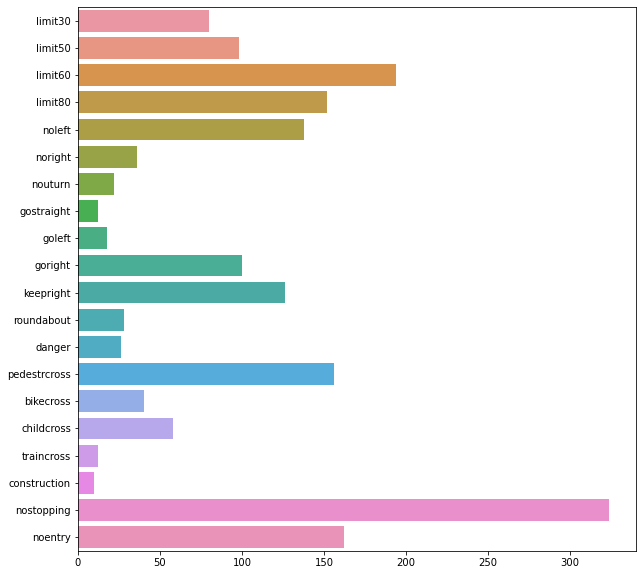

In [7]:
counter = list((Counter(train_generator.classes)).values())
fig,ax = plt.subplots(figsize=(10,10))    
p = sns.barplot(y = class_names, x = counter);

### Generate new images

In [8]:
sdir=os.getcwd() + '\\trafficsigns\\'
categories=['train']
for category in categories:
    category_path=os.path.join(sdir, category)
    filepaths=[]
    labels=[]
    classlist=os.listdir(category_path)
    for klass in classlist:
        classpath=os.path.join(category_path,klass)
        flist=os.listdir(classpath)        
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    if category=='test':
        test_df=pd.concat([Fseries, Lseries], axis=1)
    elif category=='train':
        train_df=pd.concat([Fseries, Lseries], axis=1)      

In [16]:
sample_list=[]
max_size= max(counter)
groups=train_df.groupby('labels')
for label in train_df['labels'].unique():                 
    group=groups.get_group(label)
    sample_count=len(group)    
    if sample_count> max_size:
        samples=group.sample(max_size, replace=False, weights=None, random_state=123, axis=0).reset_index(drop=True)
    else:
        samples=group.sample(frac=1.0, replace=False, random_state=123, axis=0).reset_index(drop=True)
    sample_list.append(samples)
train_df=pd.concat(sample_list, axis=0).reset_index(drop=True)    

In [17]:
import shutil
sample_list = []
max_size = max(counter) 

working_dir= os.getcwd() + '\\trafficsigns'
aug_dir=os.path.join(working_dir, 'aug')  #create new direcotry to save augmented data

if os.path.isdir(aug_dir):
    shutil.rmtree(aug_dir)
os.mkdir(aug_dir)
for label in train_df['labels'].unique():
    dir_path=os.path.join(aug_dir,label)    
    os.mkdir(dir_path)

In [18]:
target = max(counter) 
gen=ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, zoom_range=0.2, brightness_range=(0.2, 0.8))
groups=train_df.groupby('labels') # group by class
for label in train_df['labels'].unique():  # for every class               
    group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
    sample_count=len(group)   # determine how many samples there are in this class  
    if sample_count< target: # if the class has less than target number of images
        aug_img_count=0
        delta=target-sample_count  # number of augmented images to create
        target_dir=os.path.join(aug_dir, label)  # define where to write the images    
        aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=(400,400), class_mode=None, batch_size=1,
                                         shuffle=False, save_to_dir=target_dir, save_prefix='aug-',save_format='jpg')
        while aug_img_count<delta:
            images=next(aug_gen)            
            aug_img_count += len(images) 

Found 80 validated image filenames.
Found 98 validated image filenames.
Found 150 validated image filenames.
Found 150 validated image filenames.
Found 138 validated image filenames.
Found 36 validated image filenames.
Found 22 validated image filenames.
Found 12 validated image filenames.
Found 18 validated image filenames.
Found 100 validated image filenames.
Found 126 validated image filenames.
Found 28 validated image filenames.
Found 26 validated image filenames.
Found 150 validated image filenames.
Found 40 validated image filenames.
Found 58 validated image filenames.
Found 12 validated image filenames.
Found 10 validated image filenames.
Found 150 validated image filenames.
Found 150 validated image filenames.


In [19]:
aug_fpaths=[]
aug_labels=[]
classlist=os.listdir(aug_dir)
for klass in classlist:
    classpath=os.path.join(aug_dir, klass)     
    flist=os.listdir(classpath)    
    for f in flist:        
        fpath=os.path.join(classpath,f)         
        aug_fpaths.append(fpath)
        aug_labels.append(klass)
Fseries=pd.Series(aug_fpaths, name='filepaths')
Lseries=pd.Series(aug_labels, name='labels')
aug_df=pd.concat([Fseries, Lseries], axis=1)

train_df=pd.concat([train_df,aug_df], axis=0).reset_index(drop=True)
train_df=train_df.sample(frac=1.0, replace=False, random_state=123, axis=0).reset_index(drop=True)

### Save all images in file 'data.xlsx'

In [22]:
train_df.to_excel('data.xlsx')